# Numpy based image classification for Soybean crops dataset

**Dataset:** [Weed Detection in Soybean Crops](https://https://www.kaggle.com/fpeccia/weed-detection-in-soybean-crops)


## Download dataset

In [0]:
!wget https://data.mendeley.com/archiver/3fmjm7ncc6?version=2 -O soybean.zip

In [0]:
!unzip soybean.zip

In [0]:
!unzip dataset.zip

## Importing all the librabray which we need

In [0]:
import cv2
import random
import cv2
import matplotlib.pyplot as plt
import numpy as np
import sys
import os
from sklearn.model_selection import train_test_split
%matplotlib inline


## Generate Test and Training Data

In [0]:
DATASET_DIR='dataset/'

In [10]:
classes=os.listdir(DATASET_DIR)
print(classes)

['grass', 'broadleaf', 'soybean', 'soil']


In [11]:
data=[]
for cname in classes:
  path=os.path.join(DATASET_DIR,cname)
  imgs=os.listdir(path)
  data.extend([[os.path.join(path,imgname),cname] for imgname in imgs])
  print("{} : {}".format(cname,len(imgs)))

data=np.array(data)

grass : 3520
broadleaf : 1191
soybean : 7376
soil : 3249


In [0]:
random.shuffle(data)
X=data[:,0]
y=data[:,1]

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=0)

## Visualise the data

In [0]:
def sample_images(train):
    r, c = 3,5
    fig, axs = plt.subplots(r, c)
    cnt = 0
    
    for i in range(r):
        for j in range(c):
            img_path=train[i*c+j]
            img=cv2.imread(img_path)
            axs[i,j].imshow(img)
            axs[i,j].axis('off')
            cnt += 1
    plt.show()
    plt.close()

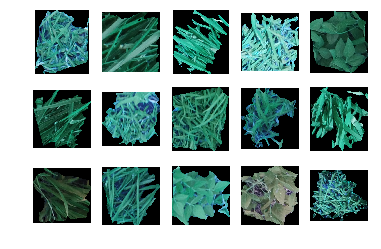

In [31]:
sample_images(X_train)

(187, 201, 3)


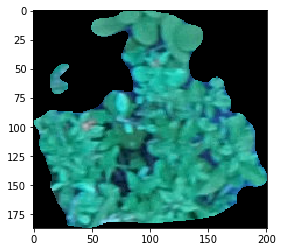

In [0]:


im = cv2.imread('/content/dataset/broadleaf/1.tif')
print(im.shape)
plt.imshow(im)
plt.show()